In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools

In [2]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [3]:
DOWN = '*down.csv'
UP = '*up.csv'
N_TYPE = 'Type'
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TRANSF_TIME = 'Transfer Time (s)'
N_DATA_SIZES = 'Data Sizes (MB)'
N_OUTLIERS = 'Outliers'
N_STARLINK = 'Starlink'
N_STARLINK_REMOTE = 'Remote'
N_HOME = 'Terrestrial'
FOLDER = 'output/SCP'

In [4]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_theme("paper", style='whitegrid', color_codes=True, 
              rc=common.sns_params, palette='bright')

In [5]:
src_dirs = []
for folder in glob.glob('data/starlink-data/SCP/*'):
    src_dirs.append((N_STARLINK, folder))
for folder in glob.glob('data/Home_network_data/SCP/*'):
    src_dirs.append((N_HOME, folder))
src_dirs

[('Starlink', 'data/starlink-data/SCP/2022-06-06_starlink_measures_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-05_starlink_measure_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-21_starlink_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-21_starlink_measures_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-06_starlink_scp'),
 ('Terrestrial', 'data/Home_network_data/SCP/2022-06-21_trad_measures_scp'),
 ('Terrestrial', 'data/Home_network_data/SCP/2022-06-06_trad_measures_scp')]

In [6]:
pattern = DOWN
df = pd.DataFrame()
for type_name, folder in src_dirs:
    files = glob.glob(f"{folder}/**/{pattern}", recursive=True)
    df_temp = pd.concat([pd.read_csv(f, index_col=False) for f in files])
    df_temp.rename(columns={'timestamp': N_TIMESTAMP, 'region': N_REGIONS}, inplace=True)
    
    df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
    df_temp = df_temp.melt([N_TIMESTAMP, N_REGIONS], var_name=N_DATA_SIZES, value_name=N_TRANSF_TIME)
    
    df_temp[N_TYPE] = type_name
    if not df.empty:
        df = df.merge(df_temp, how='outer')
    else:
        df = df_temp
df.dropna(how='all', inplace=True)
df[N_REGIONS] = df[N_REGIONS].map(common.REGION_MAP)
df[N_DATA_SIZES] = df[N_DATA_SIZES].str.removesuffix('MB').astype(int)
#df_regs_interp['sort_name'] = df_regs_interp[N_DATA_SIZES].str.pad(6, 'left', '0')
df.sort_values([N_REGIONS, N_TYPE], inplace=True, ignore_index=True)
#df_regs_interp = df_regs_interp.drop('sort_name', axis=1)
df = df.drop(df[df[N_DATA_SIZES] == 500].index)
#df[df[N_REGIONS] == 'Singapore'].sort_values(N_TRANSF_TIME).to_csv(f'{FOLDER}/out_scp.csv')
df.sort_values(N_TIMESTAMP)

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type
2095,2022-06-06 03:42:02,Sydney,1,6.559,Starlink
2096,2022-06-06 03:42:02,Sydney,10,16.777,Starlink
2097,2022-06-06 03:42:02,Sydney,100,54.596,Starlink
2098,2022-06-06 03:42:02,Sydney,200,60.726,Starlink
1812,2022-06-06 04:25:56,Singapore,100,20.027,Starlink
...,...,...,...,...,...
439,2022-06-24 02:04:32,Cape Town,300,61.539,Starlink
429,2022-06-24 02:04:32,Cape Town,200,46.842,Starlink
409,2022-06-24 02:04:32,Cape Town,10,13.251,Starlink
419,2022-06-24 02:04:32,Cape Town,100,80.029,Starlink


In [21]:
df.pivot_table(columns=[N_REGIONS, N_TYPE], values=N_TRANSF_TIME, aggfunc='count')

Regions            Bahrain             Cape Town               London  \
Type              Starlink Terrestrial  Starlink Terrestrial Starlink   
Transfer Time (s)      159         125       159         125      159   

Regions                         Mumbai             N. California              \
Type              Terrestrial Starlink Terrestrial      Starlink Terrestrial   
Transfer Time (s)         125      159         125           159         125   

Regions           Sao Paulo             Singapore               Sydney  \
Type               Starlink Terrestrial  Starlink Terrestrial Starlink   
Transfer Time (s)       159         125       159         125      160   

Regions                          Tokyo              
Type              Terrestrial Starlink Terrestrial  
Transfer Time (s)         132      159         125

In [14]:
df_latency = pd.read_csv(os.path.join('output/Ping/', '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_latency[N_TIMESTAMP] = pd.to_datetime(df_latency[N_TIMESTAMP])
df_latency

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583138,289.0,2022-06-17 08:39:47,Cape Town,Terrestrial,False
54583139,145.0,2022-06-17 08:39:47,London,Terrestrial,False
54583140,261.0,2022-06-17 08:39:47,Mumbai,Terrestrial,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Terrestrial,False


In [16]:
df_lat_scp = pd.concat([df, df_latency])

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type,Latency (ms),Outliers
0,2022-06-06 13:36:43,Bahrain,1.0,6.254,Starlink,NaN,NaN
1,2022-06-06 17:17:15,Bahrain,1.0,5.592,Starlink,NaN,NaN
2,2022-06-06 21:07:52,Bahrain,1.0,8.502,Starlink,NaN,NaN
3,2022-06-07 01:12:22,Bahrain,1.0,5.687,Starlink,NaN,NaN
4,2022-06-07 05:58:54,Bahrain,1.0,5.667,Starlink,NaN,NaN
...,...,...,...,...,...,...,...
54583138,2022-06-17 08:39:47,Cape Town,NaN,NaN,Terrestrial,289.0,False
54583139,2022-06-17 08:39:47,London,NaN,NaN,Terrestrial,145.0,False
54583140,2022-06-17 08:39:47,Mumbai,NaN,NaN,Terrestrial,261.0,False
54583141,2022-06-17 08:39:47,Sydney,NaN,NaN,Terrestrial,156.0,False


In [20]:
#df_lat_scp[(df_lat_scp[N_TIMESTAMP] > '2022-06-06 13:36:43') & (df_lat_scp[N_TIMESTAMP] < '2022-06-06 13:36:50')]

pd.Interval(pd.Timestamp('2022-06-06 13:36:43'), pd.Timestamp('2022-06-06 13:36:43') + pd.to_timedelta(6.254, unit='s'))

Interval('2022-06-06 13:36:43', '2022-06-06 13:36:49.254000', closed='right')

In [7]:
# Filter out outliers
df_outliers = df.copy()
zscore = np.abs(
    df_outliers.groupby([
        N_TYPE, N_REGIONS, N_DATA_SIZES
    ])[N_TRANSF_TIME].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_OUTLIERS] = (np.abs(zscore) >= 3)
df_outliers

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type,Outliers
0,2022-06-06 13:36:43,Bahrain,1,6.254,Starlink,False
1,2022-06-06 17:17:15,Bahrain,1,5.592,Starlink,False
2,2022-06-06 21:07:52,Bahrain,1,8.502,Starlink,False
3,2022-06-07 01:12:22,Bahrain,1,5.687,Starlink,False
4,2022-06-07 05:58:54,Bahrain,1,5.667,Starlink,False
...,...,...,...,...,...,...
2605,2022-06-08 03:06:11,Tokyo,300,25.581,Terrestrial,False
2606,2022-06-08 07:05:49,Tokyo,300,25.710,Terrestrial,False
2607,2022-06-08 11:08:40,Tokyo,300,26.763,Terrestrial,False
2608,2022-06-08 15:07:02,Tokyo,300,25.528,Terrestrial,False


In [8]:
#df_outliers = df[(np.abs(stats.zscore(df[N_TRANSF_TIME], nan_policy='omit')) >= 3)]
#df_outliers.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).mean()
#df.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).max().pivot_table(index=N_REGIONS, columns=[N_TYPE, N_DATA_SIZES])
#df[df[N_TRANSF_TIME] > 300]
#df.sort_values(N_TIMESTAMP)

In [1]:
# Aggreagation options
df_no_out.to_csv("output/SCP/out_scp_before.csv", encoding='utf-8-sig')
df_regs_interp = df.set_index(N_TIMESTAMP)
#df_regs_interp = df_regs_interp.loc['2022-06-21':]
df_regs_interp = df_regs_interp.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).resample('H').mean()
print(df_regs_interp)
#df_regs_interp = df_regs_interp.set_index([N_TYPE, N_REGIONS, N_TIMESTAMP])
df_regs_interp = df_regs_interp.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,11,1))
df_regs_interp = df_regs_interp.reset_index()

df_regs_interp

NameError: name 'df_no_out' is not defined

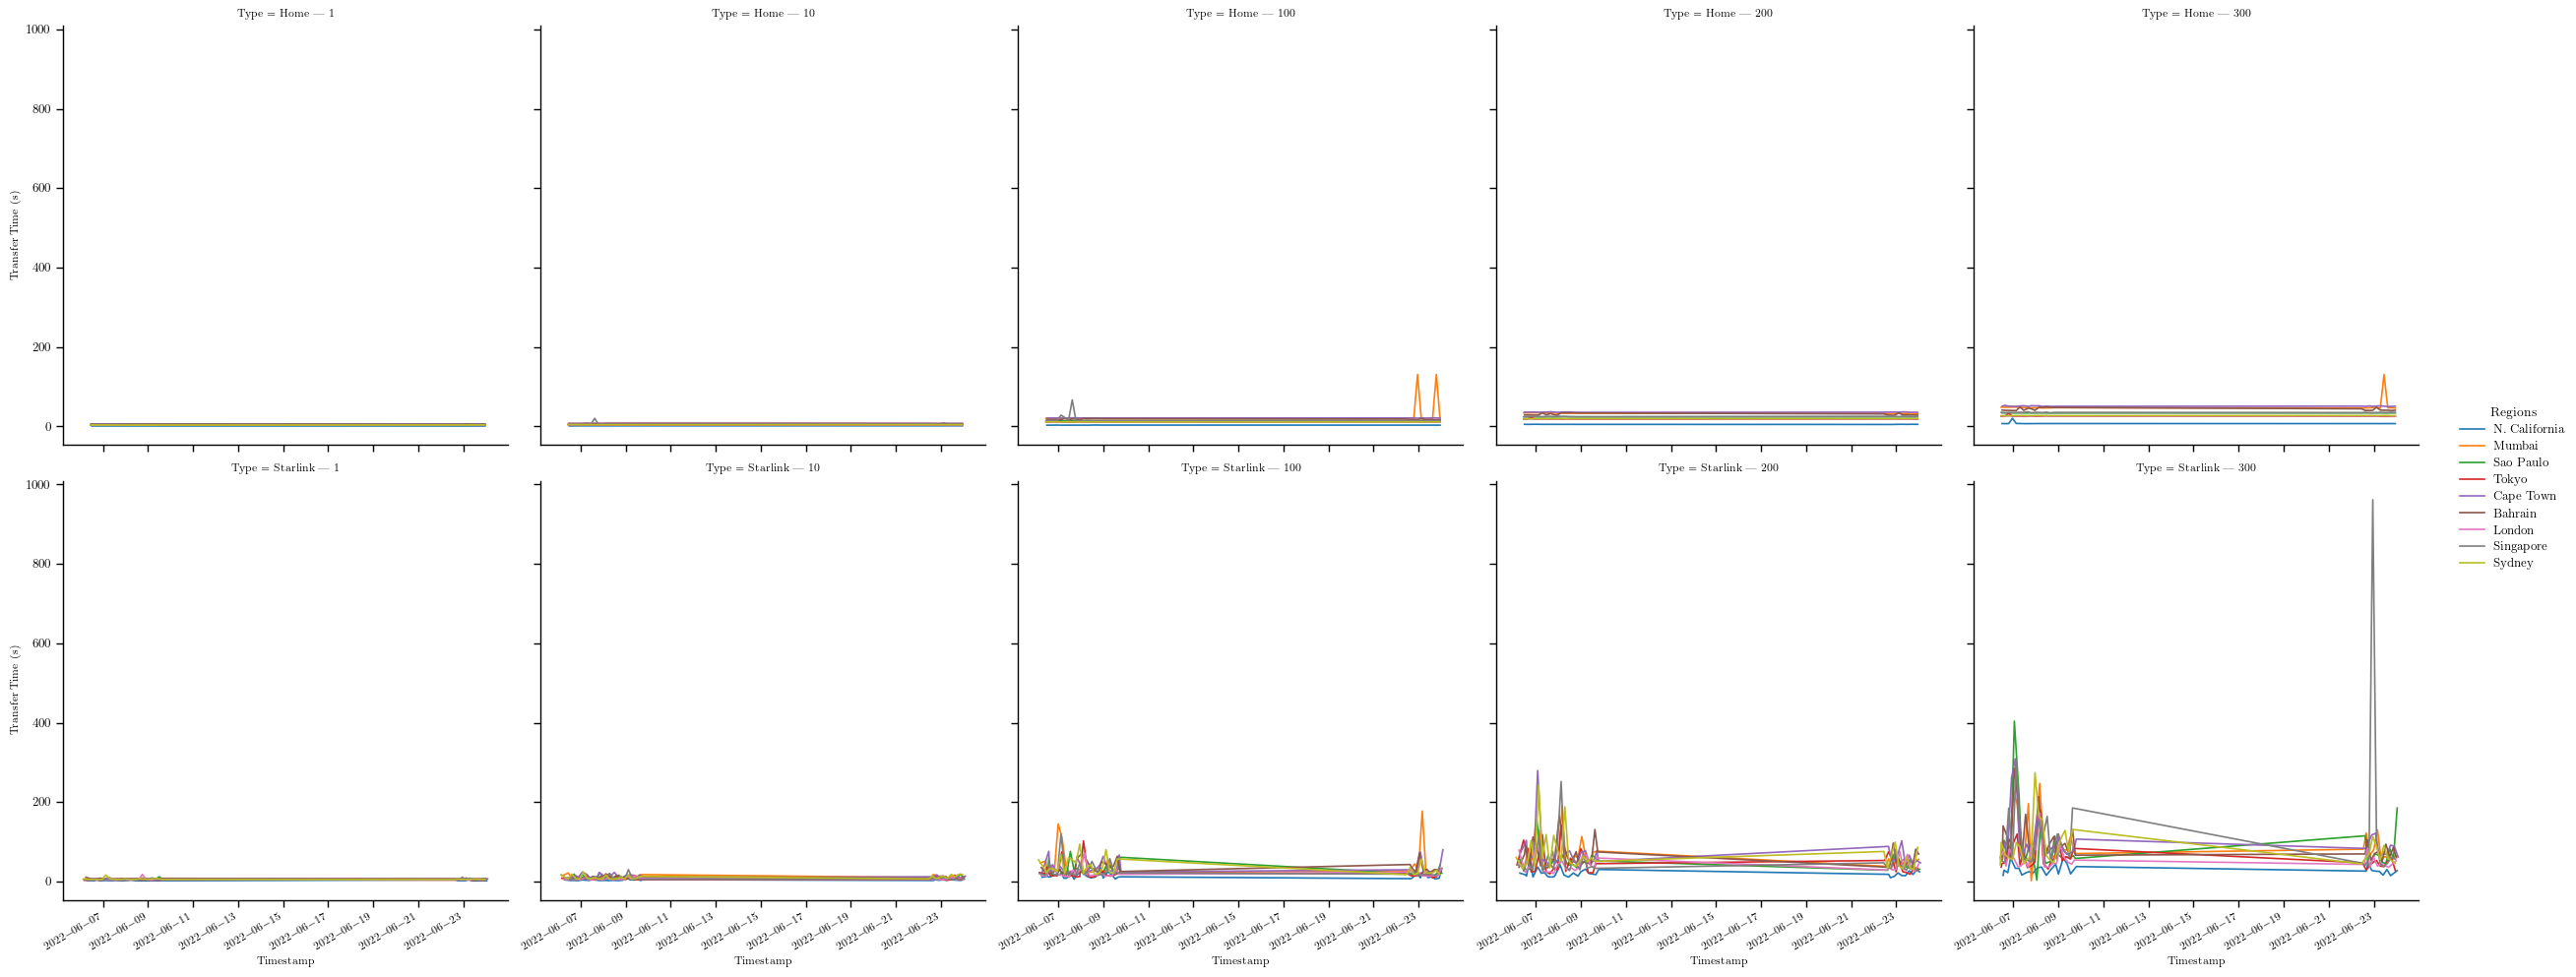

In [19]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

g = sns.relplot(data=df_regs_interp,
                x=N_TIMESTAMP, y=N_TRANSF_TIME,
                kind='line',
                col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, height=5)

#g = sfigurelineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.set_titles(col_template="{col_name}")
g.figure.autofmt_xdate()
g.tight_layout()

#fig.tight_layout()

In [14]:
#g_data = sns.catplot(data=df_regs_interp,
#                x=N_DATA_SIZES, y=N_TRANSF_TIME,
#                kind='bar',
#                col=N_REGIONS, hue=N_TYPE, height=2, aspect=0.716, col_wrap=5)
#
#g_data.set_titles(col_template="{col_name}")
#g_data.tight_layout()
df.dtypes

Timestamp            datetime64[ns]
Regions                      object
Data Sizes (MB)               int64
Transfer Time (s)           float64
Type                         object
dtype: object

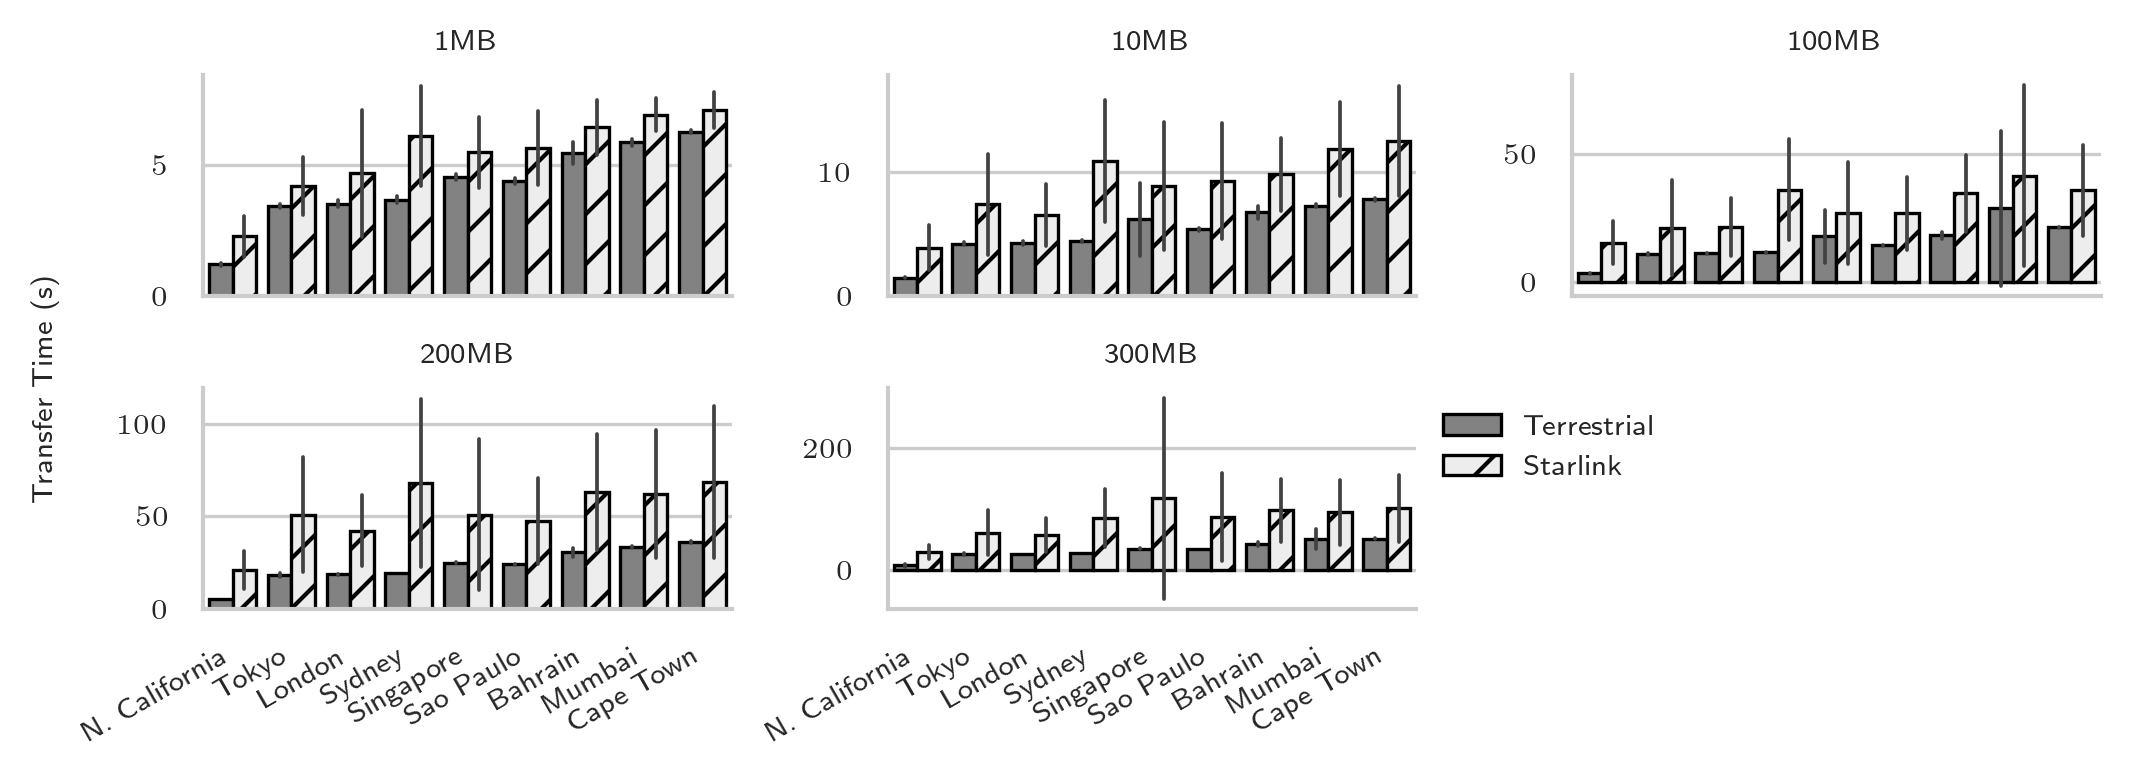

In [9]:
sns.set_palette('Greys')
h = 1.3
col_wrap = 3
aspect = 7.15 / h / col_wrap
g_data = sns.catplot(
    data=df_outliers,
    x=N_REGIONS, y=N_TRANSF_TIME,
    order=common.REGION_ORDER,
    kind='bar',
    ci='sd',
    palette=['C9', 'C0'],
    legend=False,
    sharey=False,
    col=N_DATA_SIZES, 
    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
    height=h, aspect=aspect, col_wrap=col_wrap
)

g_data.set_titles(col_template="{col_name}MB")
g_data.set(
    ylabel='',
    xlabel='',
    #yscale='log',
)
num_locs = len(df_outliers[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_data.axes.flatten()
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
axes[4].legend(loc='upper left', fancybox=True, frameon=False, mode='expand',
               bbox_to_anchor=(1, 1), title=None)
#axes[4].legend(loc='lower left', bbox_to_anchor=(1.04,0))
g_data.figure.supylabel(N_TRANSF_TIME)
g_data.figure.autofmt_xdate()
#for ax in axes:
#    ax.tick_params(axis='x', labelrotation = 90)
g_data.tight_layout()

In [10]:
g_data.savefig(f'{FOLDER}/2022-06-24_end_scp_summary.pdf', bbox_inches='tight')

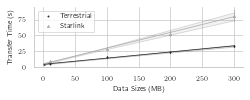

In [8]:
sns.set_palette('Greys')
h = 1.4
aspect = common.WIDTH_HALF / h
g_regress = sns.lmplot(
    data=df_outliers,
    x=N_DATA_SIZES, y=N_TRANSF_TIME,
    #col=N_DATA_SIZES, 
    #col_wrap=3
    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
    height=h, aspect=aspect,
    x_estimator=np.mean,
    palette=['C5', 'C8'],
    facet_kws=dict(legend_out=False),
    scatter_kws=dict(s=5),
    markers=['.','^'],
)

g_regress.set_titles(col_template="{col_name}MB")
g_regress.set(
    ylabel='',
    #yscale='log',
)
g_regress.set(ylabel=N_TRANSF_TIME)
axes = g_regress.axes.flatten()
g_regress._legend.set_title('')
#sns.move_legend(g_data, loc='lower center',
#               bbox_to_anchor=(.5, 1), ncol=3, title=None)
#axes[4].legend(loc='lower left', bbox_to_anchor=(1.04,0))
#for ax in axes:
#    ax.tick_params(axis='x', labelrotation = 90)
g_regress.tight_layout()

In [9]:
g_regress.savefig(f'{FOLDER}/2022-06-24_end_scp_regress.pdf', bbox_inches='tight')

In [51]:
df_outliers.sort_values(N_TIMESTAMP)

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type,Outliers
2262,2022-06-06 03:42:02,Sydney,100,54.596,Starlink,False
2260,2022-06-06 03:42:02,Sydney,1,6.559,Starlink,False
2261,2022-06-06 03:42:02,Sydney,10,16.777,Starlink,False
2263,2022-06-06 03:42:02,Sydney,200,60.726,Starlink,False
1935,2022-06-06 04:25:56,Singapore,1,4.892,Starlink,False
...,...,...,...,...,...,...
554,2022-06-24 02:04:32,Cape Town,200,46.842,Starlink,False
564,2022-06-24 02:04:32,Cape Town,300,61.539,Starlink,False
524,2022-06-24 02:04:32,Cape Town,1,6.780,Starlink,False
534,2022-06-24 02:04:32,Cape Town,10,13.251,Starlink,False


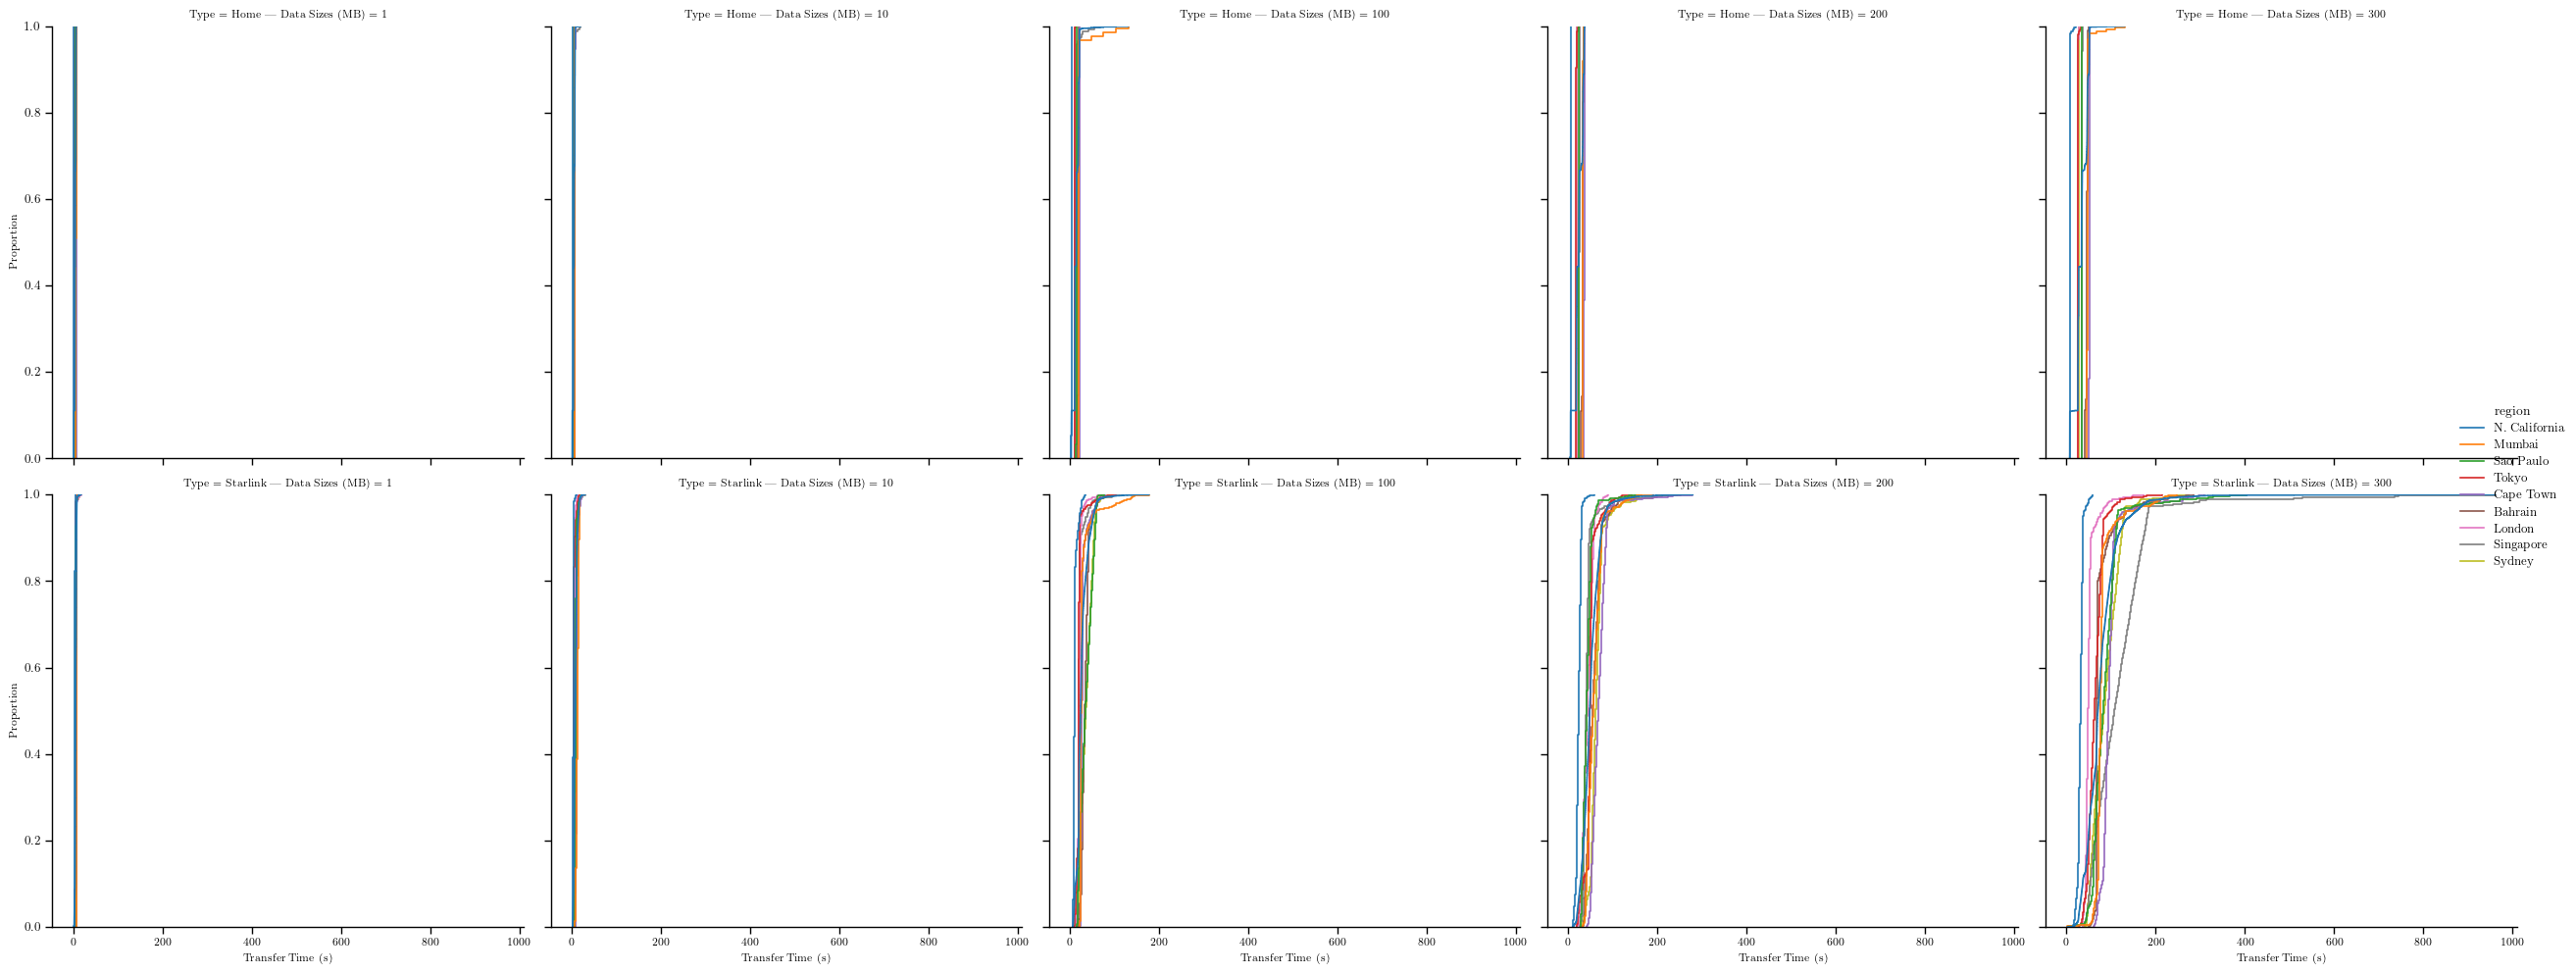

In [12]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.displot(data=df_regs_interp, x=N_TRANSF_TIME, 
                 kind='ecdf',
                 col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, height=5)
g2.map(sns.ecdfplot, N_TRANSF_TIME)
g2.add_legend()
#sns.ecdfplot(data=df_unstacked, x='bandwidth', hue=N_REGIONS)
g2.tight_layout()
#fig2.tight_layout()

In [97]:
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')
#g2.savefig(f'output/SCP/scp_cdf.pdf', bbox_inches='tight')